In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 35

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Birds Classification/train", 
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 84637 files belonging to 525 classes.


In [4]:
class_names = train_ds.class_names
class_names

['ABBOTTS BABBLER',
 'ABBOTTS BOOBY',
 'ABYSSINIAN GROUND HORNBILL',
 'AFRICAN CROWNED CRANE',
 'AFRICAN EMERALD CUCKOO',
 'AFRICAN FIREFINCH',
 'AFRICAN OYSTER CATCHER',
 'AFRICAN PIED HORNBILL',
 'AFRICAN PYGMY GOOSE',
 'ALBATROSS',
 'ALBERTS TOWHEE',
 'ALEXANDRINE PARAKEET',
 'ALPINE CHOUGH',
 'ALTAMIRA YELLOWTHROAT',
 'AMERICAN AVOCET',
 'AMERICAN BITTERN',
 'AMERICAN COOT',
 'AMERICAN DIPPER',
 'AMERICAN FLAMINGO',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL',
 'AMERICAN PIPIT',
 'AMERICAN REDSTART',
 'AMERICAN ROBIN',
 'AMERICAN WIGEON',
 'AMETHYST WOODSTAR',
 'ANDEAN GOOSE',
 'ANDEAN LAPWING',
 'ANDEAN SISKIN',
 'ANHINGA',
 'ANIANIAU',
 'ANNAS HUMMINGBIRD',
 'ANTBIRD',
 'ANTILLEAN EUPHONIA',
 'APAPANE',
 'APOSTLEBIRD',
 'ARARIPE MANAKIN',
 'ASHY STORM PETREL',
 'ASHY THRUSHBIRD',
 'ASIAN CRESTED IBIS',
 'ASIAN DOLLARD BIRD',
 'ASIAN GREEN BEE EATER',
 'ASIAN OPENBILL STORK',
 'AUCKLAND SHAQ',
 'AUSTRAL CANASTERO',
 'AUSTRALASIAN FIGBIRD',
 'AVADAVAT',
 'AZARAS SPINETAIL',
 'AZURE 

In [5]:
len(train_ds)

2645

(32, 224, 224, 3)
[ 57 429 454 179 341 391 367 506 148 104 202  55  23 108 161 107  58 340
 330 246 448 228  82  17 178  15 141 284 433  11 164 256]


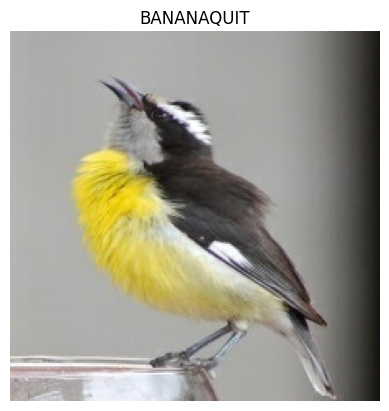

In [6]:
for image_batch, label_batch in train_ds.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Birds Classification/valid", 
    shuffle=False,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Birds Classification/test", 
    shuffle=False,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2625 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.


In [8]:
print(len(train_ds))
print(len(test_ds))
print(len(val_ds))

2645
83
83


In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

In [10]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [11]:
import pandas as pd
import numpy as np

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [13]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
n_classes = 525

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense, Conv2D, BatchNormalization, Activation,
                                     AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D, Input, concatenate, ZeroPadding2D)
from tensorflow.keras.regularizers import l2

def dense_block(x, blocks, name):
    for i in range(blocks):
        x = conv_block(x, 32, name=name + '_block' + str(i + 1))
    return x

def transition_block(x, reduction, name):
    x = BatchNormalization(axis=3, epsilon=1.001e-5, name=name + '_bn')(x)
    x = Activation('relu', name=name + '_relu')(x)
    x = Conv2D(int(tf.keras.backend.int_shape(x)[3] * reduction), 1, use_bias=False, name=name + '_conv')(x)
    x = AveragePooling2D(2, strides=2, name=name + '_pool')(x)
    return x

def conv_block(x, growth_rate, name):
    x1 = BatchNormalization(axis=3, epsilon=1.001e-5, name=name + '_0_bn')(x)
    x1 = Activation('relu', name=name + '_0_relu')(x1)
    x1 = Conv2D(4 * growth_rate, 1, use_bias=False, name=name + '_1_conv')(x1)
    x1 = BatchNormalization(axis=3, epsilon=1.001e-5, name=name + '_1_bn')(x1)
    x1 = Activation('relu', name=name + '_1_relu')(x1)
    x1 = Conv2D(growth_rate, 3, padding='same', use_bias=False, name=name + '_2_conv')(x1)
    x = concatenate([x, x1], axis=3, name=name + '_concat')
    return x

def DenseNet(blocks, input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = ZeroPadding2D(padding=((3, 3), (3, 3)))(inputs)
    x = Conv2D(64, 7, strides=2, use_bias=False, name='conv1/conv')(x)
    x = BatchNormalization(axis=3, epsilon=1.001e-5, name='conv1/bn')(x)
    x = Activation('relu', name='conv1/relu')(x)
    x = ZeroPadding2D(padding=((1, 1), (1, 1)))(x)
    x = MaxPooling2D(3, strides=2, name='pool1')(x)

    x = dense_block(x, blocks[0], name='conv2')
    x = transition_block(x, 0.5, name='pool2')
    x = dense_block(x, blocks[1], name='conv3')
    x = transition_block(x, 0.5, name='pool3')
    x = dense_block(x, blocks[2], name='conv4')
    x = transition_block(x, 0.5, name='pool4')
    x = dense_block(x, blocks[3], name='conv5')

    x = BatchNormalization(axis=3, epsilon=1.001e-5, name='bn')(x)
    x = Activation('relu', name='relu')(x)
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = Dense(num_classes, activation='softmax', name='fc' + str(num_classes))(x)

    model = Model(inputs, x, name='densenet121')
    return model

model = DenseNet([6, 12, 24, 16], input_shape=(224, 224, 3), num_classes=525)
model.summary()


Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
num_classes = 525  # Number of bird species

def preprocess(image, label):
    label = tf.one_hot(label, depth=num_classes)
    return image, label

train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)

In [18]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [19]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=16,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/35


ResourceExhaustedError: Graph execution error:

Detected at node 'densenet121/conv3_block4_concat/concat' defined at (most recent call last):
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelapp.py", line 701, in start
      self.io_loop.start()
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\asyncio\windows_events.py", line 316, in run_forever
      super().run_forever()
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue
      await self.process_one()
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one
      await dispatch(*args)
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell
      await result
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\sumer\AppData\Local\Temp\ipykernel_21844\3162266.py", line 1, in <module>
      history = model.fit(
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\keras\layers\merging\base_merge.py", line 178, in call
      return self._merge_function(inputs)
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\keras\layers\merging\concatenate.py", line 126, in _merge_function
      return backend.concatenate(inputs, axis=self.axis)
    File "C:\Users\sumer\anaconda3\envs\tf-gpu\lib\site-packages\keras\backend.py", line 3313, in concatenate
      return tf.concat([to_dense(x) for x in tensors], axis)
Node: 'densenet121/conv3_block4_concat/concat'
OOM when allocating tensor with shape[32,256,28,28] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node densenet121/conv3_block4_concat/concat}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_25300]